In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats import diagnostic
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
import sklearn.naive_bayes
from sklearn import tree
import seaborn as sns
import pandas as pd
import warnings
import sklearn

warnings.filterwarnings('ignore')

A análise exploratória pode ser encontrada [neste link](analise_exploratoria.html). Neste notebook focaremos na modelagem.

In [2]:
df = pd.read_csv('dataset/machine.data',
        names=['vendor', 'model', 'MYCT', 'MMIN', 'MMAX',
               'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP'])
conv_dict = {
'MYCT': 'machine cycle time in nanoseconds',
'MMIN': 'minimum main memory in kilobytes',
'MMAX': 'maximum main memory in kilobytes',
'CACH': 'cache memory in kilobytes',
'CHMIN': 'minimum channels in units',
'CHMAX': 'maximum channels in units',
'PRP': 'published relative performance',
'ERP': 'estimated from original article'
}

df = df.sort_values('PRP')

In [3]:
df.head(3)

,vendor,model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
99,ibm,370/125-2,480,96,512,0,1,1,6,15
181,siemens,7.521,240,512,1000,8,1,3,6,19
102,ibm,38/3,1100,512,1500,0,1,1,7,18


# Prevendo a performance dos processadores

Inicialmente, tentarei prever a performance dos processadores, assim como o artigo original, usando os dados dos mesmos. Vamos explorar algumas possibilidades, visando melhorar o resultado original, e manipulando diferentes modelos. Para início, temos uma regressão linear simples

In [4]:
X = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
y = df['PRP']
reg = LinearRegression()
scores = sklearn.model_selection.cross_val_score(reg, X, y, cv=10)
reg = reg.fit(X, y)
df['lm_pred'] = reg.predict(X)
print(f'Score: {reg.score(X, y)}')
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

Score: 0.8648906922768672
-129.14 de score com desvio padrão de 135.69
Coeficientes: [ 0.0488549   0.01529257  0.00557139  0.64140143 -0.27035755  1.48247217]
Intercepto: -55.89393360702415


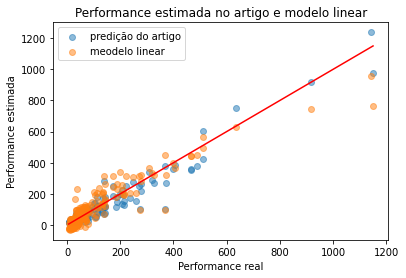

In [5]:
# Comparando o real com o estimado (em caso ideal, identidade y=x)
plt.plot(df['PRP'], df['PRP'], color='red')
plt.scatter(df['PRP'], df['ERP'], alpha=.5, label='predição do artigo')
plt.scatter(df['PRP'], df['lm_pred'], alpha=.5, label='meodelo linear')
plt.title('Performance estimada no artigo e modelo linear')
plt.xlabel('Performance real')
plt.ylabel('Performance estimada')
plt.legend()
plt.show()

In [6]:
# Usando métricas para avaliar ambos modelos
print('Modelo do artigo:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['ERP'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['ERP'])}")
print('Regressão Linear:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['lm_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['lm_pred'])}")

Modelo do artigo:
MSE: 1737.3349282296651
R2: 0.9325117107972016
Regressão Linear:
MSE: 3478.086675615355
R2: 0.8648906922768672


A regressão linear, embora bem razoavel para o problema, ainda teve menor desempenho que o modelo do artigo. Vamos tentar melhora-la. Em primeira abordagem, usarei o teste Goldfeldt-Quant para verificar se a variância dos dados apresenta correlação monótona com minhas features, o que prejudicaria a regressão (heterocedasticidade). Na função abaixo, podemos observar a f-statistic e p-valor resultados do teste, além da ordenação usada.

In [7]:
diagnostic.het_goldfeldquandt(y, X)

(55.023678187774046, 3.549091548850169e-59, 'increasing')

No caso, como suspeitado, há sim uma correlação entre as features e a variância da variável alvo. O modelo de regressão linear, porém, assume variância constante. Lidando com essa situação, podemos melhorar seu desempenho. Como alternativa, tentarei usar o modelo de regressão linear com pesos. A idéia é associar a cada ponto um peso baseado no inverso da variância do valor fitado, o que normalizará a variância do modelo. Para isso testarei pesos nas diferentes features?

In [8]:
for var in ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']:
    wls_model = sm.WLS(y,X, weights=[1/k if k else 0 for k in X[var]])
    results = wls_model.fit()
    df[f'lm_{var}'] = results.predict(X)

In [9]:
# Usando métricas para avaliar ambos modelos
print('Modelo do artigo:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['ERP'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['ERP'])}")

mse, r2 = [], []
for var in ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']:
    mse.append(sklearn.metrics.mean_squared_error(df['PRP'], df[f'lm_{var}']))
    r2.append(sklearn.metrics.r2_score(df['PRP'], df[f'lm_{var}']))

Modelo do artigo:
MSE: 1737.3349282296651
R2: 0.9325117107972016


In [10]:
print(max(r2))
print(min(mse))

0.792579718587723
5339.5708200265535


Essa abordagem não surtiu muito efeito, sendo que os parametros do modelo ficaram inferiores à regressão padrão. Vamos explorar uma outra possibilidade. Vamos analisar a correlação entre as features.

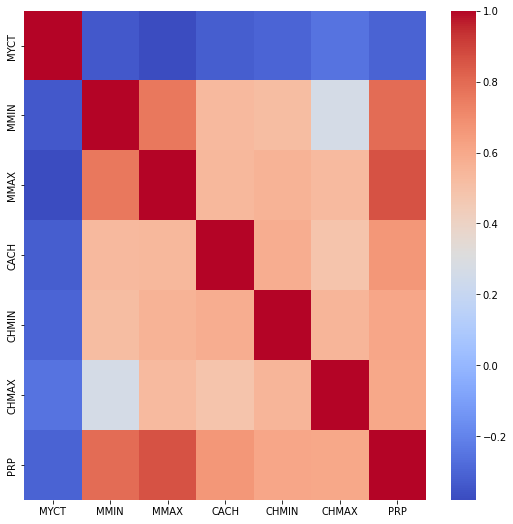

In [11]:
corr = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX','PRP']].corr()
plt.figure(figsize = (9, 9))
sns.heatmap(corr, cmap = 'coolwarm')
plt.show()

MMIN e MMAX são claramente muito correlacionadas. Alem disso, MMAX têm o maior impacto na performance que queremos prever. Vamos olhar mais essa relação:

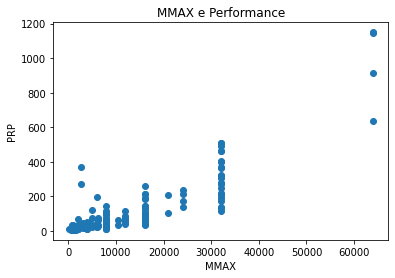

In [12]:
plt.scatter(df['MMAX'], df['PRP'])
plt.title('MMAX e Performance')
plt.xlabel('MMAX')
plt.ylabel('PRP')
plt.show()

Sera valido tentar prever a performace apenas com essa feature

In [13]:
reg = LinearRegression()
scores = sklearn.model_selection.cross_val_score(reg, df[['MMAX']], df['PRP'], cv=10)
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
reg = reg.fit(df[['MMAX']], df['PRP'])
df['mmax_pred'] = reg.predict(df[['MMAX']])
print(f"Score: {reg.score(df[['MMAX']], df['PRP'])}")
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

-138.09 de score com desvio padrão de 132.84
Score: 0.744776118671232
Coeficientes: [0.01183617]
Intercepto: -33.99924034304276


In [14]:
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['mmax_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['mmax_pred'])}")

MSE: 6570.167488145871
R2: 0.744776118671232


Realmente, temos um modelo um pouco pior, mas com grande capacidade preditiva, que só confirma a grande representatividade dessa variável. A validação cruzada, ainda, retorna estimativas múito próximas do modelo original com todas as variáveis. Apliquemos agora PCA mais efetivamente para decidir as variáveis mais relevantes.

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
X2 = pca.transform(X)

[9.60283667e-01 3.93281442e-02 3.77860090e-04]
[174601.19757958  35334.51821049   3463.48219169]


In [16]:
reg = LinearRegression()
scores = sklearn.model_selection.cross_val_score(reg, X2, y, cv=10)
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
reg = reg.fit(X2, y)
df['pca_pred'] = reg.predict(X2)
print(f"Score: {reg.score(X2, y)}")
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

-98.52 de score com desvio padrão de 99.16
Score: 0.7927394489374597
Coeficientes: [0.01160048 0.01113437 0.0255988 ]
Intercepto: 105.622009569378


In [17]:
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['pca_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['pca_pred'])}")

MSE: 5335.4589197402365
R2: 0.7927394489374597


Com 3 das 6 componentes principais conseguimos um modelo quase tão bom quanto o inicial, visto que a relevancia das variáveis é geterogeneamente distribuida. Vamos partir para outra abordagem, Support Vector Machines.

In [18]:
clf = sklearn.svm.SVR()
scores = sklearn.model_selection.cross_val_score(clf, X, y)
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
clf = clf.fit(X,y)
df['svr_pred'] = clf.predict(X)
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['svr_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['svr_pred'])}")

-17.32 de score com desvio padrão de 20.04
MSE: 24609.26974144917
R2: 0.04403147234656657


Vale a tentativa de normalizar os dados para o SVR, já que é baseado em distâncias, e gostaríamos de dar igual peso à todas as featres e amplitudes. Não faz sentido usar diretamente os valores originais.

In [19]:
df2 = pd.DataFrame(StandardScaler().fit_transform(df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP']]), columns=['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP'])
X2 = df2[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
y2 = df2['PRP']
clf = sklearn.svm.SVR()
scores = sklearn.model_selection.cross_val_score(clf, X2, y2)
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
clf = clf.fit(X2,y2)
p = clf.predict(X2)
print(f"MSE: {sklearn.metrics.mean_squared_error(y2, p)}")
print(f"R2: {sklearn.metrics.r2_score(y2, p)}")

-33.61 de score com desvio padrão de 46.59
MSE: 0.20876276433939414
R2: 0.7912372356606059


Legal! Com um simples classificador SVC conseguimos melhorar o resultado da regressão linear. Vamos tentar ainda alguns ajustes, variando o kernel, para além do linear, e averiguando os resultados:

In [20]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    print(kernel)
    clf = sklearn.svm.SVR(kernel=kernel)
    scores = sklearn.model_selection.cross_val_score(clf, X2, y2)
    print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
    clf = clf.fit(X2,y2)
    df[f'svc_{kernel}_pred'] = clf.predict(X2)
    print(f"MSE: {sklearn.metrics.mean_squared_error(y2, df[f'svc_{kernel}_pred'])}")
    print(f"R2: {sklearn.metrics.r2_score(y2, df[f'svc_{kernel}_pred'])}")

linear
-20.90 de score com desvio padrão de 20.31
MSE: 0.18143136716380073
R2: 0.8185686328361992
poly
-54.84 de score com desvio padrão de 44.31
MSE: 0.06991653318087668
R2: 0.9300834668191234
rbf
-33.61 de score com desvio padrão de 46.59
MSE: 0.20876276433939414
R2: 0.7912372356606059
sigmoid
-1452.02 de score com desvio padrão de 1490.39
MSE: 33.06316767978462
R2: -32.06316767978462


Como esperado pela natureza dos dados, o kernel Linear surtiu bastante efeito positivo. Além disso, curiosamente, polinomial parece ter se ajustado ainda melhor aos dados, embora não necessariamente tenha muita capacidade de generalização, que podemos visualizar pela pior perormance na validação cruzada.

Será um equívoco generalizar os processadores por vendedor? Será que se isolarmos os processadores da fábrica mais representativa conseguimos um modelo melhor?

In [21]:
sorted(Counter(df['vendor']).items(), key=lambda x:-x[1])

[('ibm', 32),
 ('nas', 19),
 ('ncr', 13),
 ('sperry', 13),
 ('honeywell', 13),
 ('siemens', 12),
 ('cdc', 9),
 ('amdahl', 9),
 ('burroughs', 8),
 ('hp', 7),
 ('dg', 7),
 ('harris', 7),
 ('magnuson', 6),
 ('dec', 6),
 ('c.r.d', 6),
 ('ipl', 6),
 ('formation', 5),
 ('cambex', 5),
 ('prime', 5),
 ('perkin-elmer', 3),
 ('nixdorf', 3),
 ('gould', 3),
 ('bti', 2),
 ('apollo', 2),
 ('wang', 2),
 ('basf', 2),
 ('microdata', 1),
 ('four-phase', 1),
 ('sratus', 1),
 ('adviser', 1)]

In [22]:
X2 = df[df['vendor']=='ibm'][['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
y2 = df[df['vendor']=='ibm']['PRP']

In [23]:
reg = LinearRegression()
scores = sklearn.model_selection.cross_val_score(reg, X2, y2, cv=10)
reg = reg.fit(X2, y2)
p = reg.predict(X2)
print(f'Score: {reg.score(X2, y2)}')
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

Score: 0.989859557711665
-23.28 de score com desvio padrão de 35.04
Coeficientes: [ 2.52582303e-02  1.45607723e-02  1.80612711e-03  1.24793188e+00
 -7.95949640e-02  5.20190755e+00]
Intercepto: -35.48071475660305


In [24]:
print(f"MSE: {sklearn.metrics.mean_squared_error(y2, p)}")
print(f"R2: {sklearn.metrics.r2_score(y2, p)}")

MSE: 140.74386272714315
R2: 0.989859557711665


Eureca! Analisar as fabricantes separadamente parece produzir um efeito muito mais claro na regressão. Isso condiz completamente com a natureza dos dados, uma vez que as arquiteturas de uma fabricante devem ser muito semelhantes. Vamos expandir para algumas das fabricantes mais comuns para visualizar. Infelizmente as mais raras apresentam poucos dados, no meu dataset que já é escasso.

In [25]:
fabricantes = [v[0] for v in sorted(Counter(df['vendor']).items(), key=lambda x:-x[1])[:10]]
ac, mse, r2 = [], [], []
for f in fabricantes:
    X2 = df[df['vendor']==f][['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
    y2 = df[df['vendor']==f]['PRP']
    reg = LinearRegression()
    scores = sklearn.model_selection.cross_val_score(reg, X2, y2, cv=3)
    reg = reg.fit(X2, y2)
    p = reg.predict(X2)
    ac.append(scores.mean())
    mse.append(sklearn.metrics.mean_squared_error(y2, p))
    r2.append(sklearn.metrics.r2_score(y2, p))

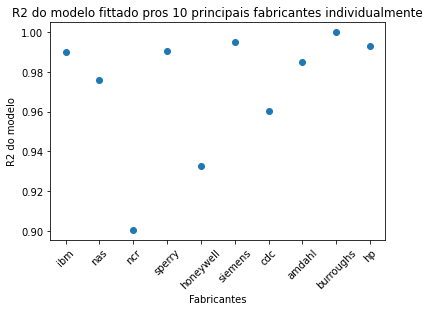

In [26]:
plt.scatter(fabricantes, r2)
plt.xticks(rotation=45)
plt.xlabel('Fabricantes')
plt.ylabel('R2 do modelo')
plt.title('R2 do modelo fittado pros 10 principais fabricantes individualmente')
plt.show()

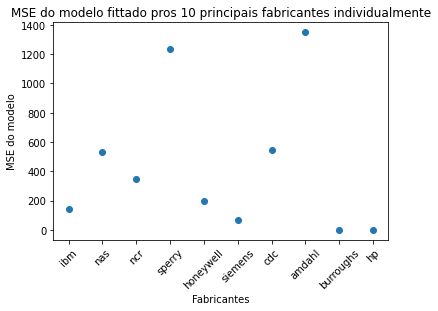

In [27]:
plt.scatter(fabricantes, mse)
plt.xticks(rotation=45)
plt.xlabel('Fabricantes')
plt.ylabel('MSE do modelo')
plt.title('MSE do modelo fittado pros 10 principais fabricantes individualmente')
plt.show()

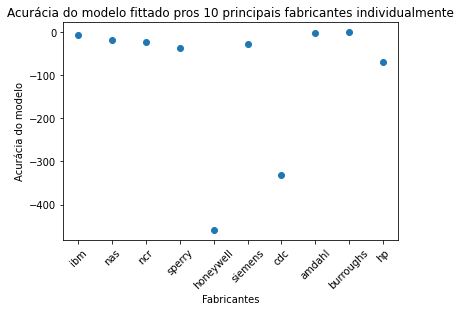

In [28]:
plt.scatter(fabricantes, ac)
plt.xticks(rotation=45)
plt.xlabel('Fabricantes')
plt.ylabel('Acurácia do modelo')
plt.title('Acurácia do modelo fittado pros 10 principais fabricantes individualmente')
plt.show()

A previsão por fabricante foi MUITO mais eficaz! Vamos investigar um pouco mais as relações das features separando por fabricantes.

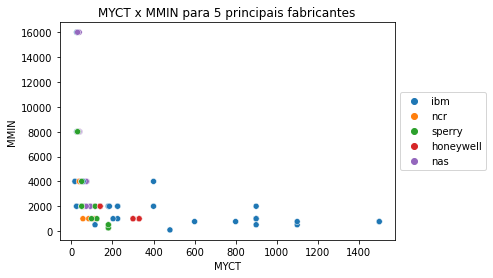

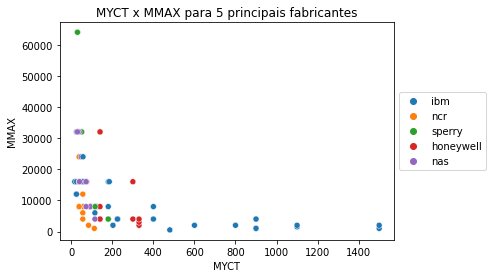

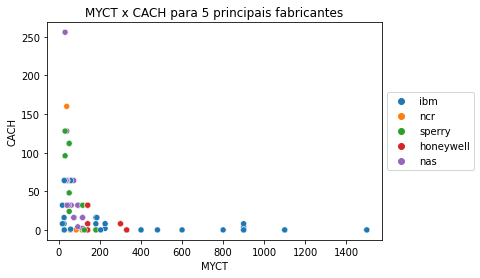

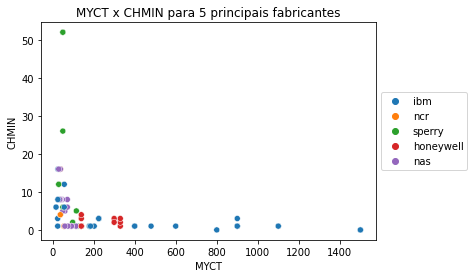

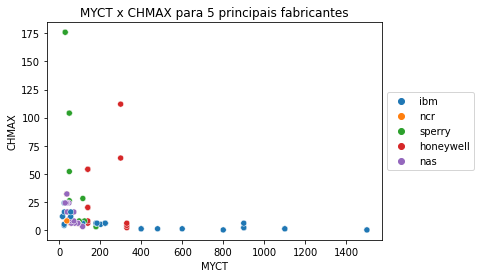

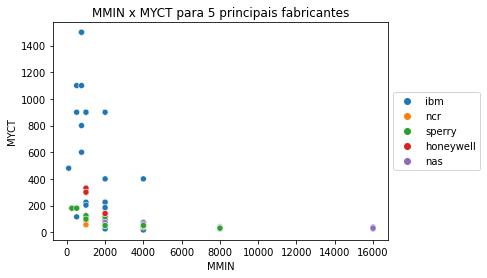

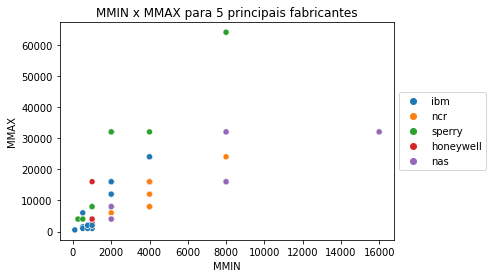

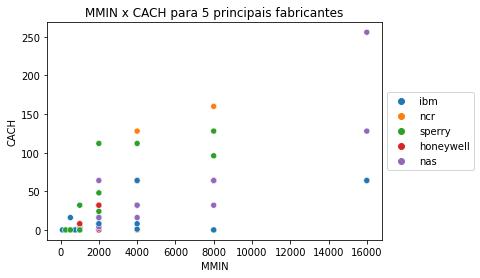

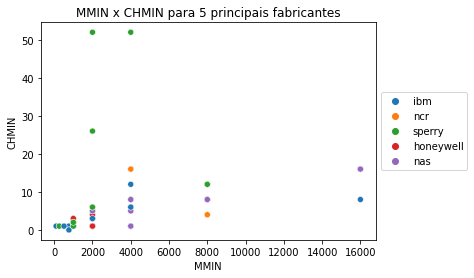

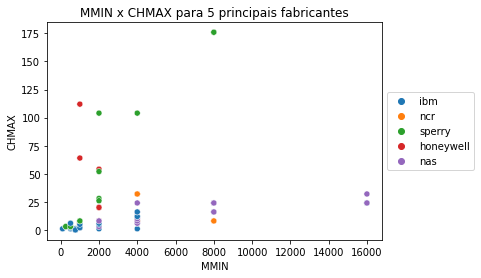

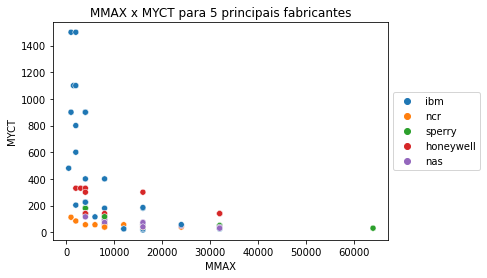

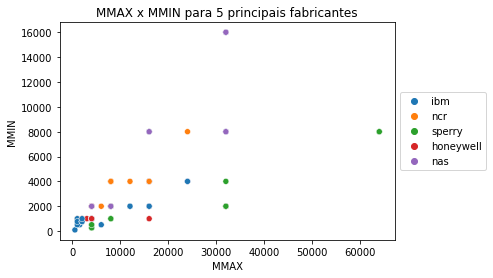

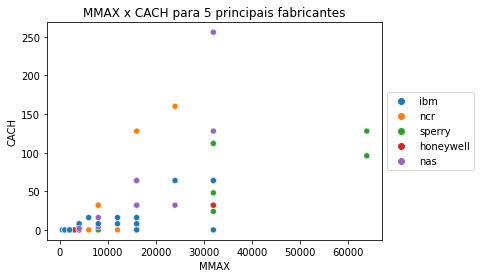

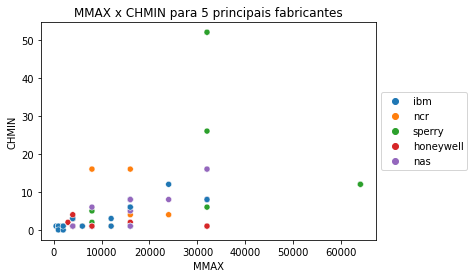

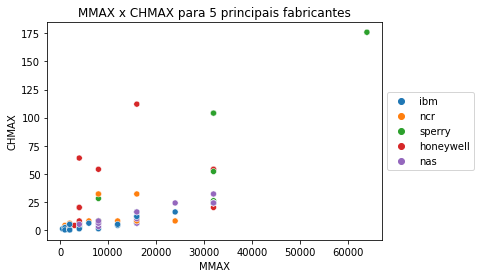

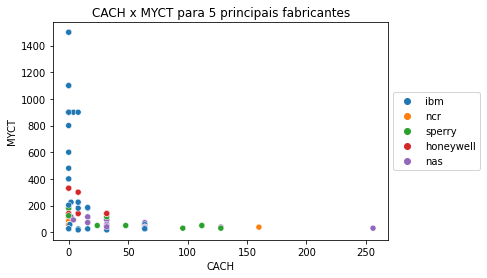

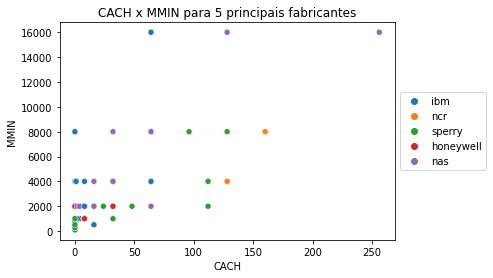

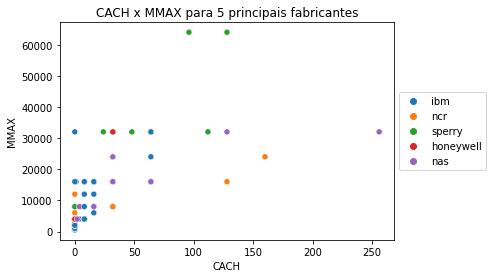

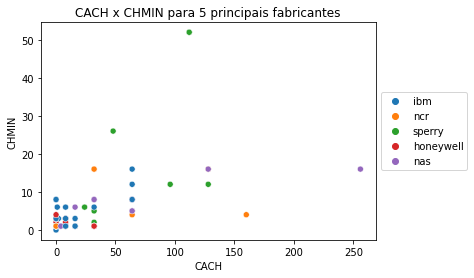

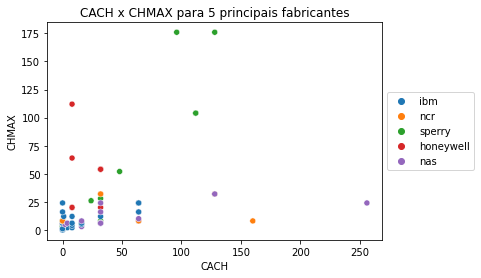

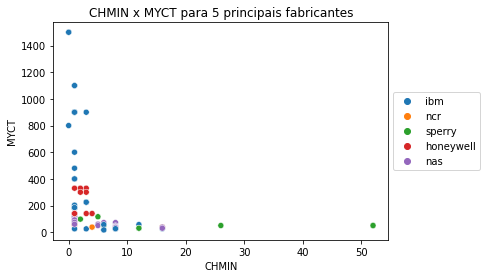

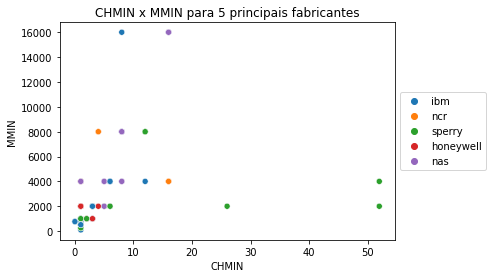

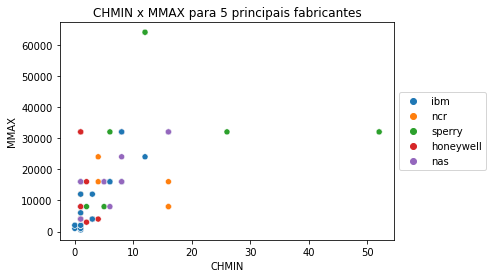

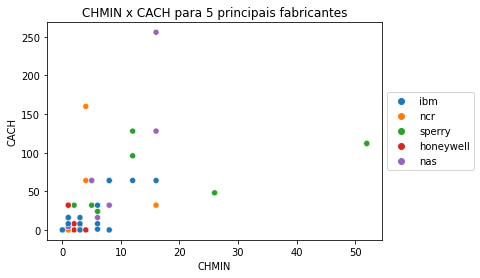

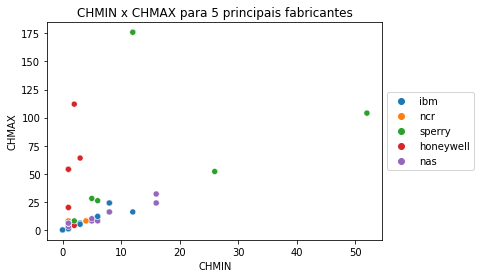

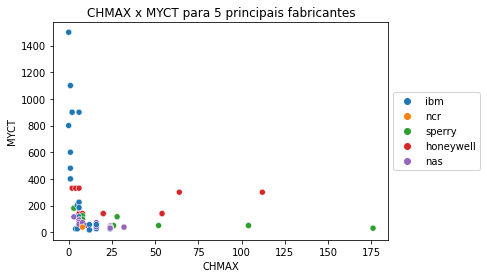

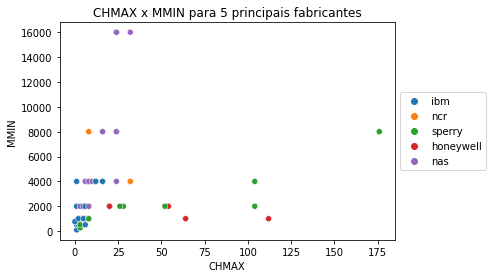

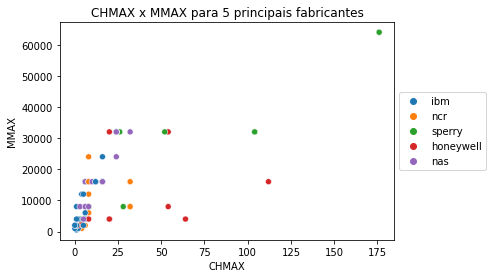

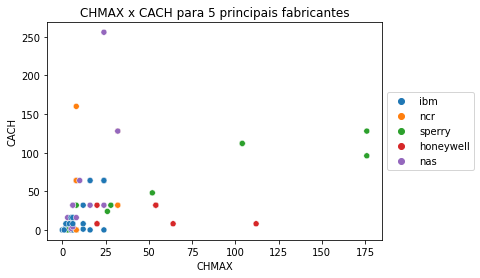

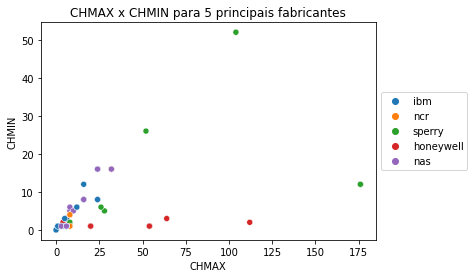

In [29]:
df2 = df[df['vendor'].isin(fabricantes[:5])]
for f1 in ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']:
    for f2 in ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']:
        if f1==f2: continue
#         plt.scatter(df[f1], df[f2])
        sns.scatterplot(f1, f2, data=df2, hue='vendor')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel(f1)
        plt.ylabel(f2)
        plt.title(f"{f1} x {f2} para 5 principais fabricantes")
        plt.show()

Convenientemene parece que esbarramos em um caso classico de paradoxo de Simpson. Agregar as informações dos processadores acabou reduzindo a informação presente nas suas propriedades e features. A variável de fabricante é relevante para a modelagem, mesmo que não impacte direta ou intuitivamente na performance dos dispositivos.

# Prevendo o fabricante pelo processador


A última análise me fez ponderar se era possível fazer o contrário: tentar prever o fabricante com base nos dados do processador, agora incluindo o PRP como feature também. Vale a tentativa :)

In [30]:
df2 = pd.DataFrame(StandardScaler().fit_transform(df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP']]), columns=['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP'])
X2 = df2[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP']]
y2 = df['vendor']

In [31]:
clf = sklearn.svm.SVC()
scores = sklearn.model_selection.cross_val_score(clf, X2, y2)
clf = clf.fit(X2, y2)
p = clf.predict(X2)
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
print("Acurácia:", sklearn.metrics.accuracy_score(y2, p))

0.18 de score com desvio padrão de 0.04
Acurácia: 0.37799043062200954


Bom, da para melhorar. Uma classificação com support vectors foi extremamente imprecisa. Tentemos com um Naive Bayes Classifier.

In [32]:
clf = sklearn.naive_bayes.GaussianNB()
scores = sklearn.model_selection.cross_val_score(clf, X2, y2)
clf = clf.fit(X2, y2)
p = clf.predict(X2)
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
print("Acurácia:", sklearn.metrics.accuracy_score(y2, p))

0.37 de score com desvio padrão de 0.15
Acurácia: 0.5263157894736842


Por último, vale a tentativa de uma RandomForest

In [33]:
clf = RandomForestClassifier(max_depth=5)
scores = sklearn.model_selection.cross_val_score(clf, X2, y2)
clf = clf.fit(X2, y2)
p = clf.predict(X2)
print("%0.2f de score com desvio padrão de %0.2f" % (scores.mean(), scores.std()))
print("Acurácia:", sklearn.metrics.accuracy_score(y2, p))

0.51 de score com desvio padrão de 0.17
Acurácia: 0.8325358851674641


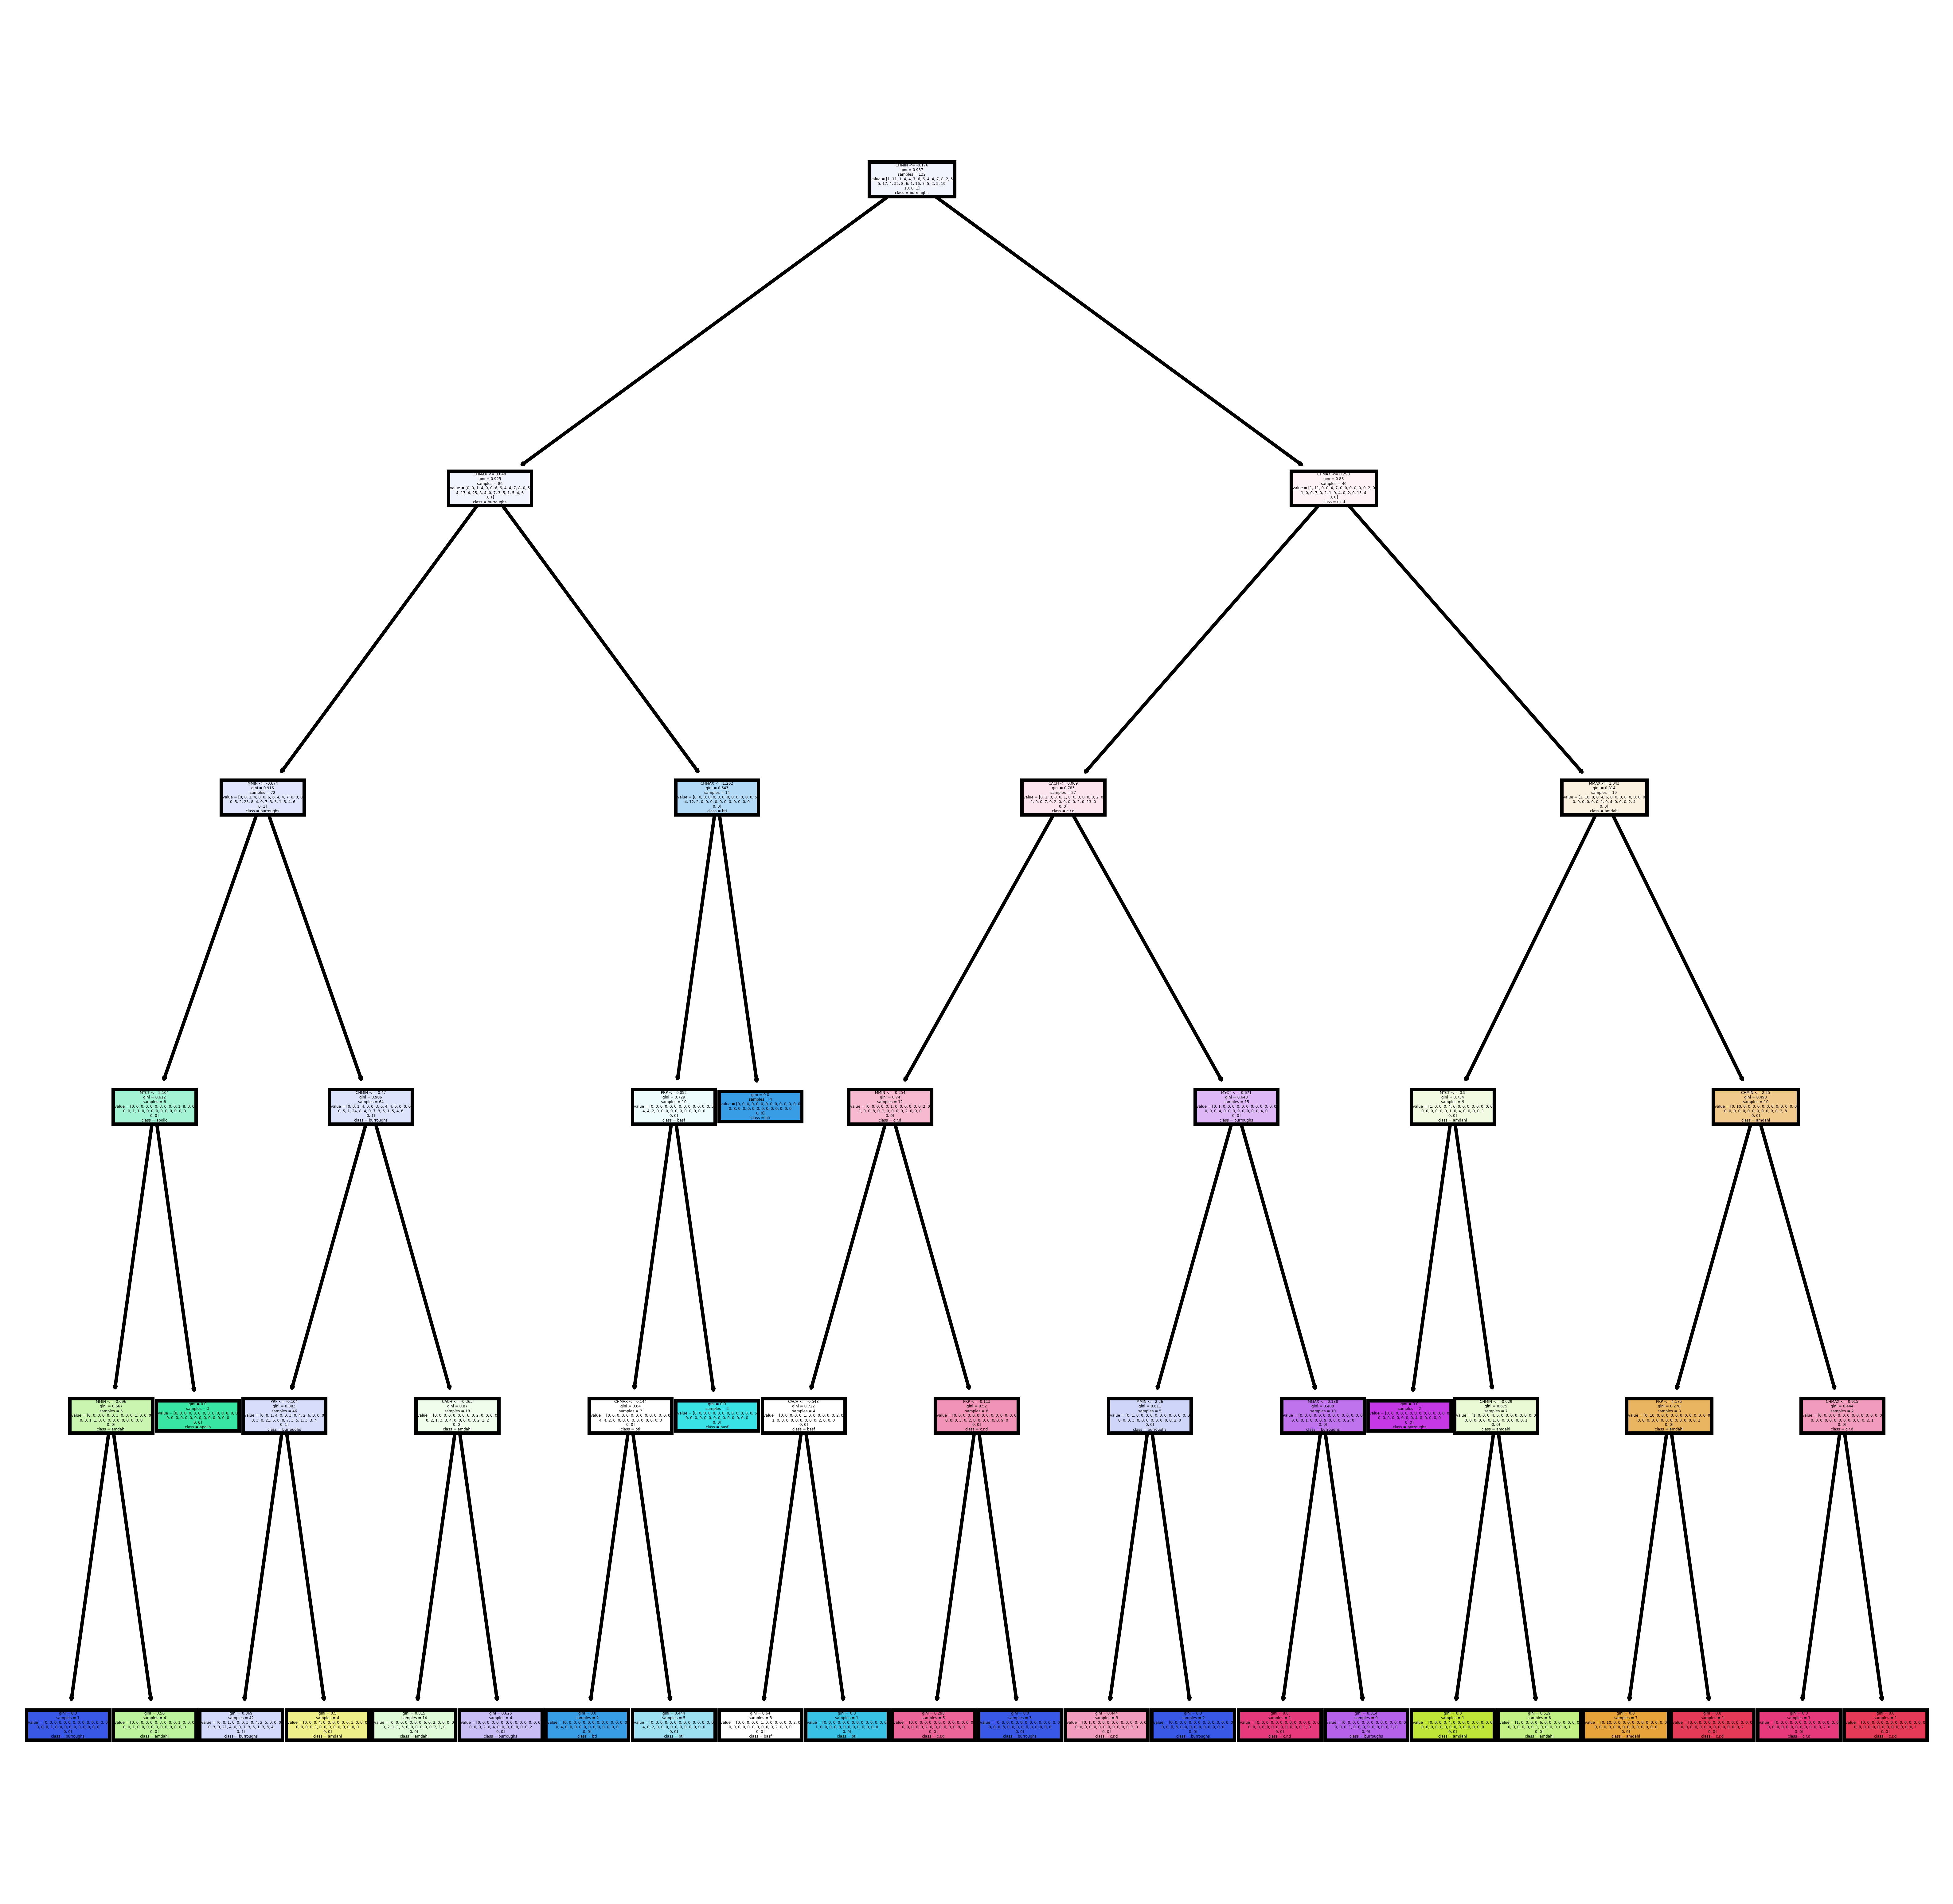

In [34]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=800)
tree.plot_tree(clf.estimators_[0],
               feature_names = X2.columns, 
               class_names=y2,
               filled = True);

Random Forests conseguiram determinar bastante bem os fabricantes! Permitindo maior número de profundidade conseguimos acurácia bem maior. Infelizmente não temos muitos dados para faze-lo de forma segura garantindo que não estão sendo dividios modelos individuais

# Clusterizando os dados

O que acontece se eu forçar uma clusterização dos dados? Será que algo de interessante pode ser obtido?

In [35]:
df = df[['vendor', 'model', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP']].copy()
X = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP']]
df.head()

,vendor,model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
99,ibm,370/125-2,480,96,512,0,1,1,6
181,siemens,7.521,240,512,1000,8,1,3,6
102,ibm,38/3,1100,512,1500,0,1,1,7
157,ncr,v8535:ii,112,1000,1000,0,1,4,8
14,bti,5000,350,64,64,0,1,4,10


In [36]:
sil = []
for k in range(2,16):
    p = KMeans(n_clusters=k).fit_predict(X)
    sil.append(sklearn.metrics.silhouette_score(X, p))

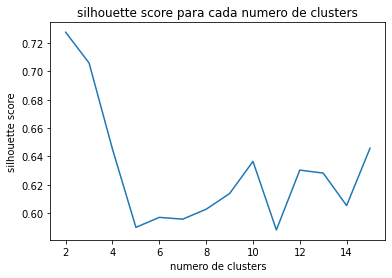

In [37]:
plt.plot(range(2,16), sil)
plt.title('silhouette score para cada numero de clusters')
plt.xlabel('numero de clusters')
plt.ylabel('silhouette score')
plt.show()

In [38]:
p = KMeans(n_clusters=3).fit_predict(X)

Cluster 0
              MYCT         MMIN          MMAX        CACH       CHMIN  \
count   176.000000   176.000000    176.000000  176.000000  176.000000   
mean    233.602273  1755.272727   7587.818182   16.636364    2.994318   
std     273.253103  1633.941455   5032.506044   31.938577    3.257514   
min      17.000000    64.000000     64.000000    0.000000    0.000000   
25%      59.750000   521.000000   4000.000000    0.000000    1.000000   
50%     140.000000  1000.000000   8000.000000    8.000000    1.000000   
75%     300.000000  2000.000000  12000.000000   16.000000    4.000000   
max    1500.000000  8000.000000  16000.000000  256.000000   16.000000   

            CHMAX         PRP  
count  176.000000  176.000000  
mean    13.659091   56.670455  
std     19.181769   52.692796  
min      0.000000    6.000000  
25%      4.000000   24.000000  
50%      6.000000   40.000000  
75%     16.000000   66.250000  
max    128.000000  368.000000  


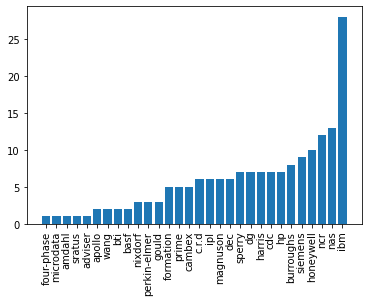

Cluster 1
             MYCT          MMIN          MMAX        CACH      CHMIN  \
count   29.000000     29.000000     29.000000   29.000000  29.000000   
mean    47.551724   7809.655172  30135.862069   66.344828  13.206897   
std     34.006918   4863.069638   3772.771355   51.815797  12.271859   
min     23.000000   2000.000000  20970.000000    0.000000   1.000000   
25%     26.000000   4000.000000  32000.000000   32.000000   8.000000   
50%     38.000000   8000.000000  32000.000000   64.000000   8.000000   
75%     50.000000   8000.000000  32000.000000   64.000000  16.000000   
max    140.000000  16000.000000  32000.000000  256.000000  52.000000   

            CHMAX         PRP  
count   29.000000   29.000000  
mean    33.310345  284.689655  
std     22.240734  124.980599  
min      8.000000  106.000000  
25%     24.000000  189.000000  
50%     24.000000  269.000000  
75%     32.000000  370.000000  
max    104.000000  510.000000  


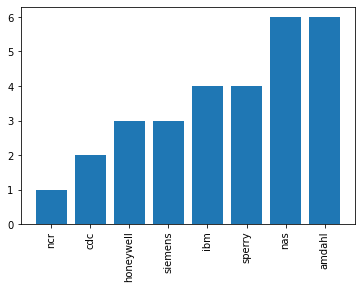

Cluster 2
            MYCT          MMIN     MMAX        CACH      CHMIN       CHMAX  \
count   4.000000      4.000000      4.0    4.000000   4.000000    4.000000   
mean   26.500000  16000.000000  64000.0  104.000000  18.000000  112.000000   
std     4.041452  11313.708499      0.0   30.637667   9.521905   75.046652   
min    23.000000   8000.000000  64000.0   64.000000  12.000000   32.000000   
25%    23.000000   8000.000000  64000.0   88.000000  12.000000   56.000000   
50%    26.500000  12000.000000  64000.0  112.000000  14.000000  120.000000   
75%    30.000000  20000.000000  64000.0  128.000000  20.000000  176.000000   
max    30.000000  32000.000000  64000.0  128.000000  32.000000  176.000000   

               PRP  
count     4.000000  
mean    961.250000  
std     242.865361  
min     636.000000  
25%     845.250000  
50%    1029.500000  
75%    1145.500000  
max    1150.000000  


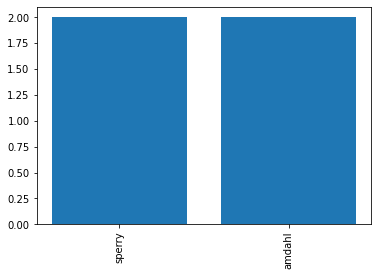

In [39]:
for k in range(3):
    print("Cluster", k)
    tmp = df[p==k]
    print(tmp.describe())
    d = sorted([(k,len(tmp[tmp['vendor']==k])) for k in set(tmp['vendor'])], key=lambda x:x[1])
    plt.bar([x[0] for x in d], [x[1] for x in d])
    plt.xticks(rotation=90)
    plt.show()